# Neural Network for Sentiment Analysis

## Experimenting with padded word-to-index sequences

In [25]:
import numpy as np 
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import time
import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# scipy.special for the sigmoid function expit()
import scipy.special
# library for plotting arrays
import matplotlib.pyplot
# ensure the plots are inside this notebook, not an external window
%matplotlib inline

## Text Preprocessing

In [28]:
def get_wordnet_pos(tag):
    """Take a POS tag and return the corresponding WordNet POS tag.

    Parameter:
    -tag: a POS tag.
    """
    
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  # Default to noun if the POS is not recognized

In [30]:
def preprocess_text(text,remove_digits=True):
    """Read a csv file and clean the text by removing html string using the BeautifulSoup library.
    Apply tokenization and lemmatization.
    Return the df with the preprocessed text in the respective column.
    
    Parameters:
    -reviews_file: path to a csv file containing the final reviews, provided as a Python string.
    -text_column: name of the column in the csv file where the reviews are stored, provided as a Python string.
    """
    
    #removing HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    #removing square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    #removing special characters
    if remove_digits:
        text = re.sub('[^a-zA-Z\s]', '', text)
    else:
        text = re.sub('[^a-zA-Z0-9\s]', '', text)
    
    #lowercasing the text
    text = text.lower()

    #tokenization with NLTK
    tokens = nltk.word_tokenize(text)

    #removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    #lemmatization with POS tagging
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens) #applying the NLTK POS tags to tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags] #lemmatizing each token based on its POS
    lemmatized_text = ' '.join(lemmatized_tokens)  #joining lemmatized tokens back into a single string

    return lemmatized_text

###part of the code as seen on https://www.kaggle.com/code/aashidutt3/sentiment-analysis-sephora-reviews/notebook on Jan 23rd

In [4]:
output_file_path = './sephora-data/sa-reviews_smaller.csv'
text_column = 'text'

# reading the csv file into a DataFrame with pandas
df = pd.read_csv(output_file_path)
# applying the preprocessing function to the text column
df[text_column] = df[text_column].apply(preprocess_text)

/var/folders/c3/6b53cyc56hdcsrh90312r_1w0000gn/T/ipykernel_2533/1751978500.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
/var/folders/c3/6b53cyc56hdcsrh90312r_1w0000gn/T/ipykernel_2533/1751978500.py:12: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


## Splitting Data into Train and Test

In [5]:
def plot_sentence_length_histogram(data, bins=30):
    """
    Plot a histogram of sentence lengths in words for the given dataset.
    Return the pandas Series containing the lengths of words in sentences.

    Parameters:
    - data: list or series of text reviews in the dataset, as a pandas df format.
    - bins: number of bins for the histogram, the default is set to 30. The higher the number, the more detailed view of the distribution.
    """
    
    pd_histogram = pd.Series([len(review.split()) for review in data])
    
    # plotting the histogram
    fig, ax = matplotlib.pyplot.subplots()
    sns.histplot(pd_histogram, bins=bins, ax=ax)
    ax.set_xlabel("Sentences length")
    
    # displaying summary statistics
    print(pd_histogram.describe())
    
    return pd_histogram
    
### code for plotting sentence length as seen at https://www.kaggle.com/code/themeeemul/sephora-eda-and-sentiment-analysis-using-pytorch/notebook on 30th Jan 2024

In [6]:
# Split data into training and test sets
reviews_tr, reviews_test, gold_labels_tr, gold_labels_test = train_test_split(df['text'], # the text column with all the reviews in the df
                                                                                    df['label'], # the labels for all the data
                                                                                    test_size = 0.20 # we use 80% for training and 20% for test
                                                                                   )

# Split data into training and dev sets
reviews_train, reviews_dev, gold_labels_train, gold_labels_dev = train_test_split(reviews_tr, # the text column with the reviews in the reduced df resulting from the split above
                                                                                    gold_labels_tr, # the labels for training data resulting from the split above
                                                                                    test_size = 0.20 # we use 80% for training and 20% for development
                                                                                   )

In [7]:
print("Training texts:", len(reviews_train))
print("Training labels:", len(gold_labels_train))
print("Test texts:", len(reviews_test))
print("Test labels:", len(gold_labels_test))
print("Development texts:", len(reviews_dev))
print("Development labels:", len(gold_labels_dev))

Training texts: 31939
Training labels: 31939
Test texts: 9981
Test labels: 9981
Development texts: 7985
Development labels: 7985


count    31939.000000
mean        29.388647
std         20.908002
min          1.000000
25%         15.000000
50%         24.000000
75%         37.000000
max        200.000000
dtype: float64
0    10
1    16
2    19
3     8
4    35
dtype: int64


/Users/arianabritez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


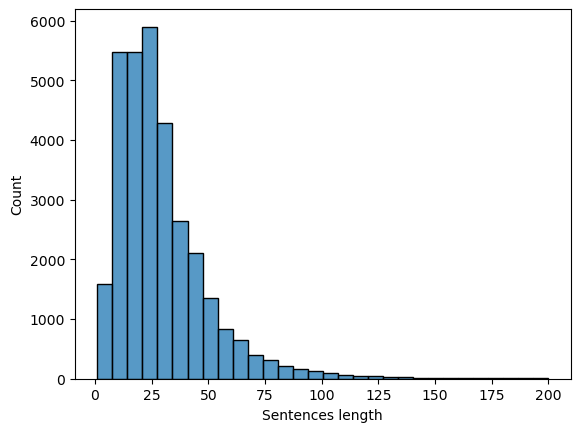

In [8]:
#checking the average length in words in the reviews text under training split
pd_histogram = plot_sentence_length_histogram(reviews_train)
print(pd_histogram.head())

## NN input preprocessing

In [1]:
def training_data_padded_sequences(reviews_train, min_df=300, max_len=35):
    """
    Tokenize and preprocess training text data using CountVectorizer and applying padding.
    Return the padded sequence vectors for the training data and a dictionary mapping words to indices.
    
    Parameters:
    - reviews_train: list of training sentences.
    - min_df: minimum frequency of a token to be considered, default set to 300.
    - max_len: maximum length of vector sequences after padding, default set to 35.
    """
    
    X_train_sequences = [] #empty list where the sequences of word indices per sentence will be stored
    
    #tokenization with CountVectorizer,  if a token appears fewer times than stated, it will be ignored
    vectorizer = CountVectorizer(min_df=min_df)

    #fit and transform the training data
    X_train_counts = vectorizer.fit_transform(reviews_train)

    #getting the vocabulary and creating a mapping of words to indices
    vocab = vectorizer.vocabulary_
    word_to_index = {word: index for index, word in enumerate(vocab.keys())}

    #converting sentences to sequences for training data
    for sentence in reviews_train:
        word_indices = [word_to_index[word] for word in nltk.word_tokenize(sentence) if word in word_to_index] #tokenizing each sentence in the training data into sequences of word indices
        X_train_sequences.append(word_indices) #append the sequence of word indices for a sentence to the sequence list

    #padding the sequences for training data
    X_train_padded = np.array([seq[:max_len] + [0] * max(0, max_len - len(seq)) for seq in X_train_sequences])

    return X_train_padded, word_to_index

In [2]:
def dev_test_data_padded_sequences(reviews_dev, word_to_index, max_len=35):
    """
    Tokenize and preprocess dev/test data using precomputed word-to-index mapping.
    Return the padded sequence vectors for the dev/test data.
    
    Parameters:
    - reviews_dev: list of dev/test sentences.
    - word_to_index: a dictionary mapping words to indices.
    - max_len: maximum length of sequences after padding, default set to 35..
    """
    
    X_dev_test_sequences = [] #empty list where the sequences of word indices per sentence will be stored
    
    #X_test_counts = vectorizer.transform(reviews_dev)
    
    #converting sentences to sequences for dev/test data
    for sentence in reviews_dev_test:
        word_indices = [word_to_index[word] for word in nltk.word_tokenize(sentence) if word in word_to_index] #tokenizing each sentence in the data into sequences of word indices
        X_dev_test_sequences.append(word_indices) #append the sequence of word indices for a sentence to the sequence list

    #padding sequences for dev/test data
    X_dev_padded = np.array([seq[:max_len] + [0] * max(0, max_len - len(seq)) for seq in X_dev_sequences])

    return X_dev_padded

In [11]:
#preprocessing to pad sequences in both training and dev data
max_len=35
X_train_padded, word_to_index = training_data_padded_sequences(reviews_train)
X_dev_padded = dev_test_data_padded_sequences(reviews_dev, word_to_index)

print(X_train_padded.shape)
print(X_dev_padded.shape)


(31939, 35)
(7985, 35)


## Building the Neural Network

In [13]:
# neural network class definition
class neuralNetwork:
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        #set the number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to nodej in the next layer
        # w11 w21
        # w12 w22 etc
        #self.wih = (numpy.random.rand(self.hnodes, self.inodes) - 0.5) ##random initialization
        #self.who = (numpy.random.rand(self.onodes, self.hnodes) - 0.5)
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5),(self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5),(self.onodes, self.hnodes))
        
        #learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)

        pass
        
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        #calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors)

        # update the weights for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))

        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        
        pass
        
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T                                
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)

        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs


In [14]:
# number of input, hidden and output nodes
input_nodes = max_len #this is the size of padded embedding vector
hidden_nodes = 500
output_nodes = 30

# learning rate
learning_rate = 0.3

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

## Training the NN

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

###code taken from https://www.kaggle.com/code/themeeemul/sephora-eda-and-sentiment-analysis-using-pytorch/notebook on 26th Jan - useful to print how long the epochs take

In [16]:
def train_nn(nn, reviews_train, gold_labels_train, epochs, max_count):
    """
    Train a neural network with the provided training dataset and gold labels.
    Return None.

    Parameters:
    - nn: an instance of the neural network class
    - reviews_train: the training dataset (features)
    - gold_labels_train: the training gold labels
    - epochs: number of times the training data set is ran for training
    - max_count: maximum count for normalization, integer given by the max number of an item in the vocabulary array
    """
    
    output_nodes = nn.onodes  #number of output nodes in the nn

    for epoch in range(epochs):
        # Measure how long the training epoch takes.
        t0 = time.time()
        
        #iterating over each training instance
        for array, (index, value) in zip(reviews_train, gold_labels_train.items()):
            #normalizing the inputs
            inputs = (array / float(max_count) * 0.99) + 0.01

            # creating the target output values (all 0.01, except the desired label which is 0.99)
            targets = np.zeros(output_nodes) + 0.01
            #the value of the label is the target label for this record
            targets[int(value)] = 0.99

            #training the neural network
            nn.train(inputs, targets)
            
        # Measure elapsed time for the epoch.
        elapsed_time = time.time() - t0

        # Print the epoch training time.
        print(f"Epoch {epoch + 1}/{epochs}, Elapsed Time: {format_time(elapsed_time)}")

In [17]:
def test_nn(nn, data_test, g_labels_test, max_count):
    """
    Test a neural network with the test or development data for validation.
    Return the classification report with the error metrics and print the confusion matrix.

    Parameters:
    - nn: an instance of the neural network class
    - data_test: the test or dev dataset (features)
    - g_labels_test: the test or dev labels
    - max_count: maximum count for normalization, integer given by the max number of an item in the vocabulary array

    Print classification report with error metrics: precision, recall, F1 and accuracy.
    Plot the confusion matrix.
    """
    
    labels = ['0','1']
    human_labels_test = []
    system_labels_pred = []

    # go through all the records in the test/dev data set
    for array, (index, value) in zip(data_test, g_labels_test.items()):
        # normalizing the inputs
        inputs = (array / float(max_count) * 0.99) + 0.01
        # correct answer is the first value
        correct_label = int(value)
        human_labels_test.append(str(correct_label))

        # query the network
        outputs = nn.query(inputs)
        # the index of the highest value corresponds to the predicted label
        predicted_label = np.argmax(outputs)

        # append correct or incorrect to the scorecard
        if predicted_label == correct_label:
            # network's answer matches correct answer, add 1 to scorecard
            system_labels_pred.append('1')
        else:
            # network's answer doesn't match correct answer, add 0 to scorecard
            system_labels_pred.append('0')

    report = classification_report(human_labels_test, system_labels_pred, digits = 2, target_names = labels)
    cf_matrix = confusion_matrix(human_labels_test, system_labels_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
    print(report)
    print(cf_matrix)
    display.plot()

In [18]:
max_count = X_train_padded.max()
train_nn(n, X_train_padded, gold_labels_train, epochs=5, max_count=max_count)

Epoch 1/5, Elapsed Time: 0:00:07
Epoch 2/5, Elapsed Time: 0:00:06
Epoch 3/5, Elapsed Time: 0:00:06
Epoch 4/5, Elapsed Time: 0:00:06
Epoch 5/5, Elapsed Time: 0:00:06


              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3993
           1       0.92      0.94      0.93      3992

    accuracy                           0.93      7985
   macro avg       0.93      0.93      0.93      7985
weighted avg       0.93      0.93      0.93      7985

[[3655  338]
 [ 245 3747]]


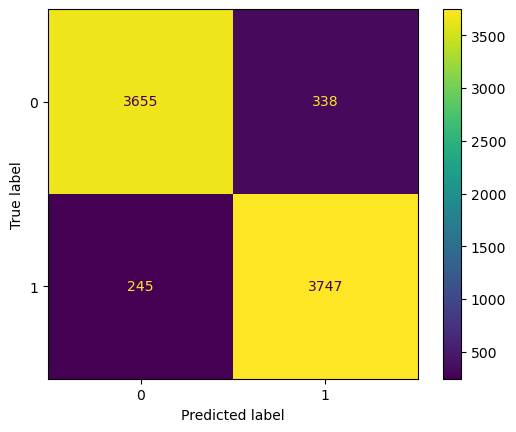

In [19]:
test_nn(n, X_dev_padded, gold_labels_dev, max_count)

## Evaluation on test dataset

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      5029
           1       0.91      0.94      0.92      4952

    accuracy                           0.92      9981
   macro avg       0.92      0.92      0.92      9981
weighted avg       0.92      0.92      0.92      9981

[[4548  481]
 [ 321 4631]]


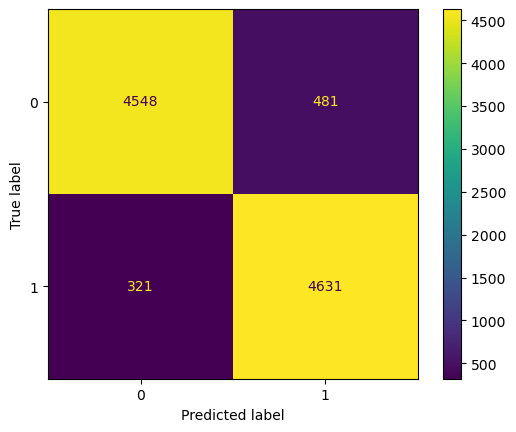

In [21]:
X_test_padded = process_dev_test_data(reviews_test, vec, word_to_index)
test_nn(n, X_test_padded, gold_labels_test, max_count)